In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
import seaborn as sns
from jax import random, vmap
from jaxlib.xla_extension import ArrayImpl
from numpyro.infer import MCMC, NUTS
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def generate_synthetic_data(
    rng_key: ArrayImpl, start: float, stop: float, num: int, scale: float
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    x = jnp.linspace(start=start, stop=stop, num=num)
    y = jnp.sin(4 * jnp.pi * x) + jnp.sin(7 * jnp.pi * x)
    y_obs = y + scale * random.normal(rng_key, shape=(num,))
    return x, y, y_obs


n_train = 80
n_test = 100
scale = 0.3

rng_key, rng_subkey = random.split(rng_key)
x_train, y_train, y_train_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=0, stop=1, num=n_train, scale=scale
)

rng_key, rng_subkey = random.split(rng_key)
x_test, y_test, y_test_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=-0.2, stop=1.2, num=n_test, scale=scale
)

Text(0.5, 1.0, 'Synthetic Data')

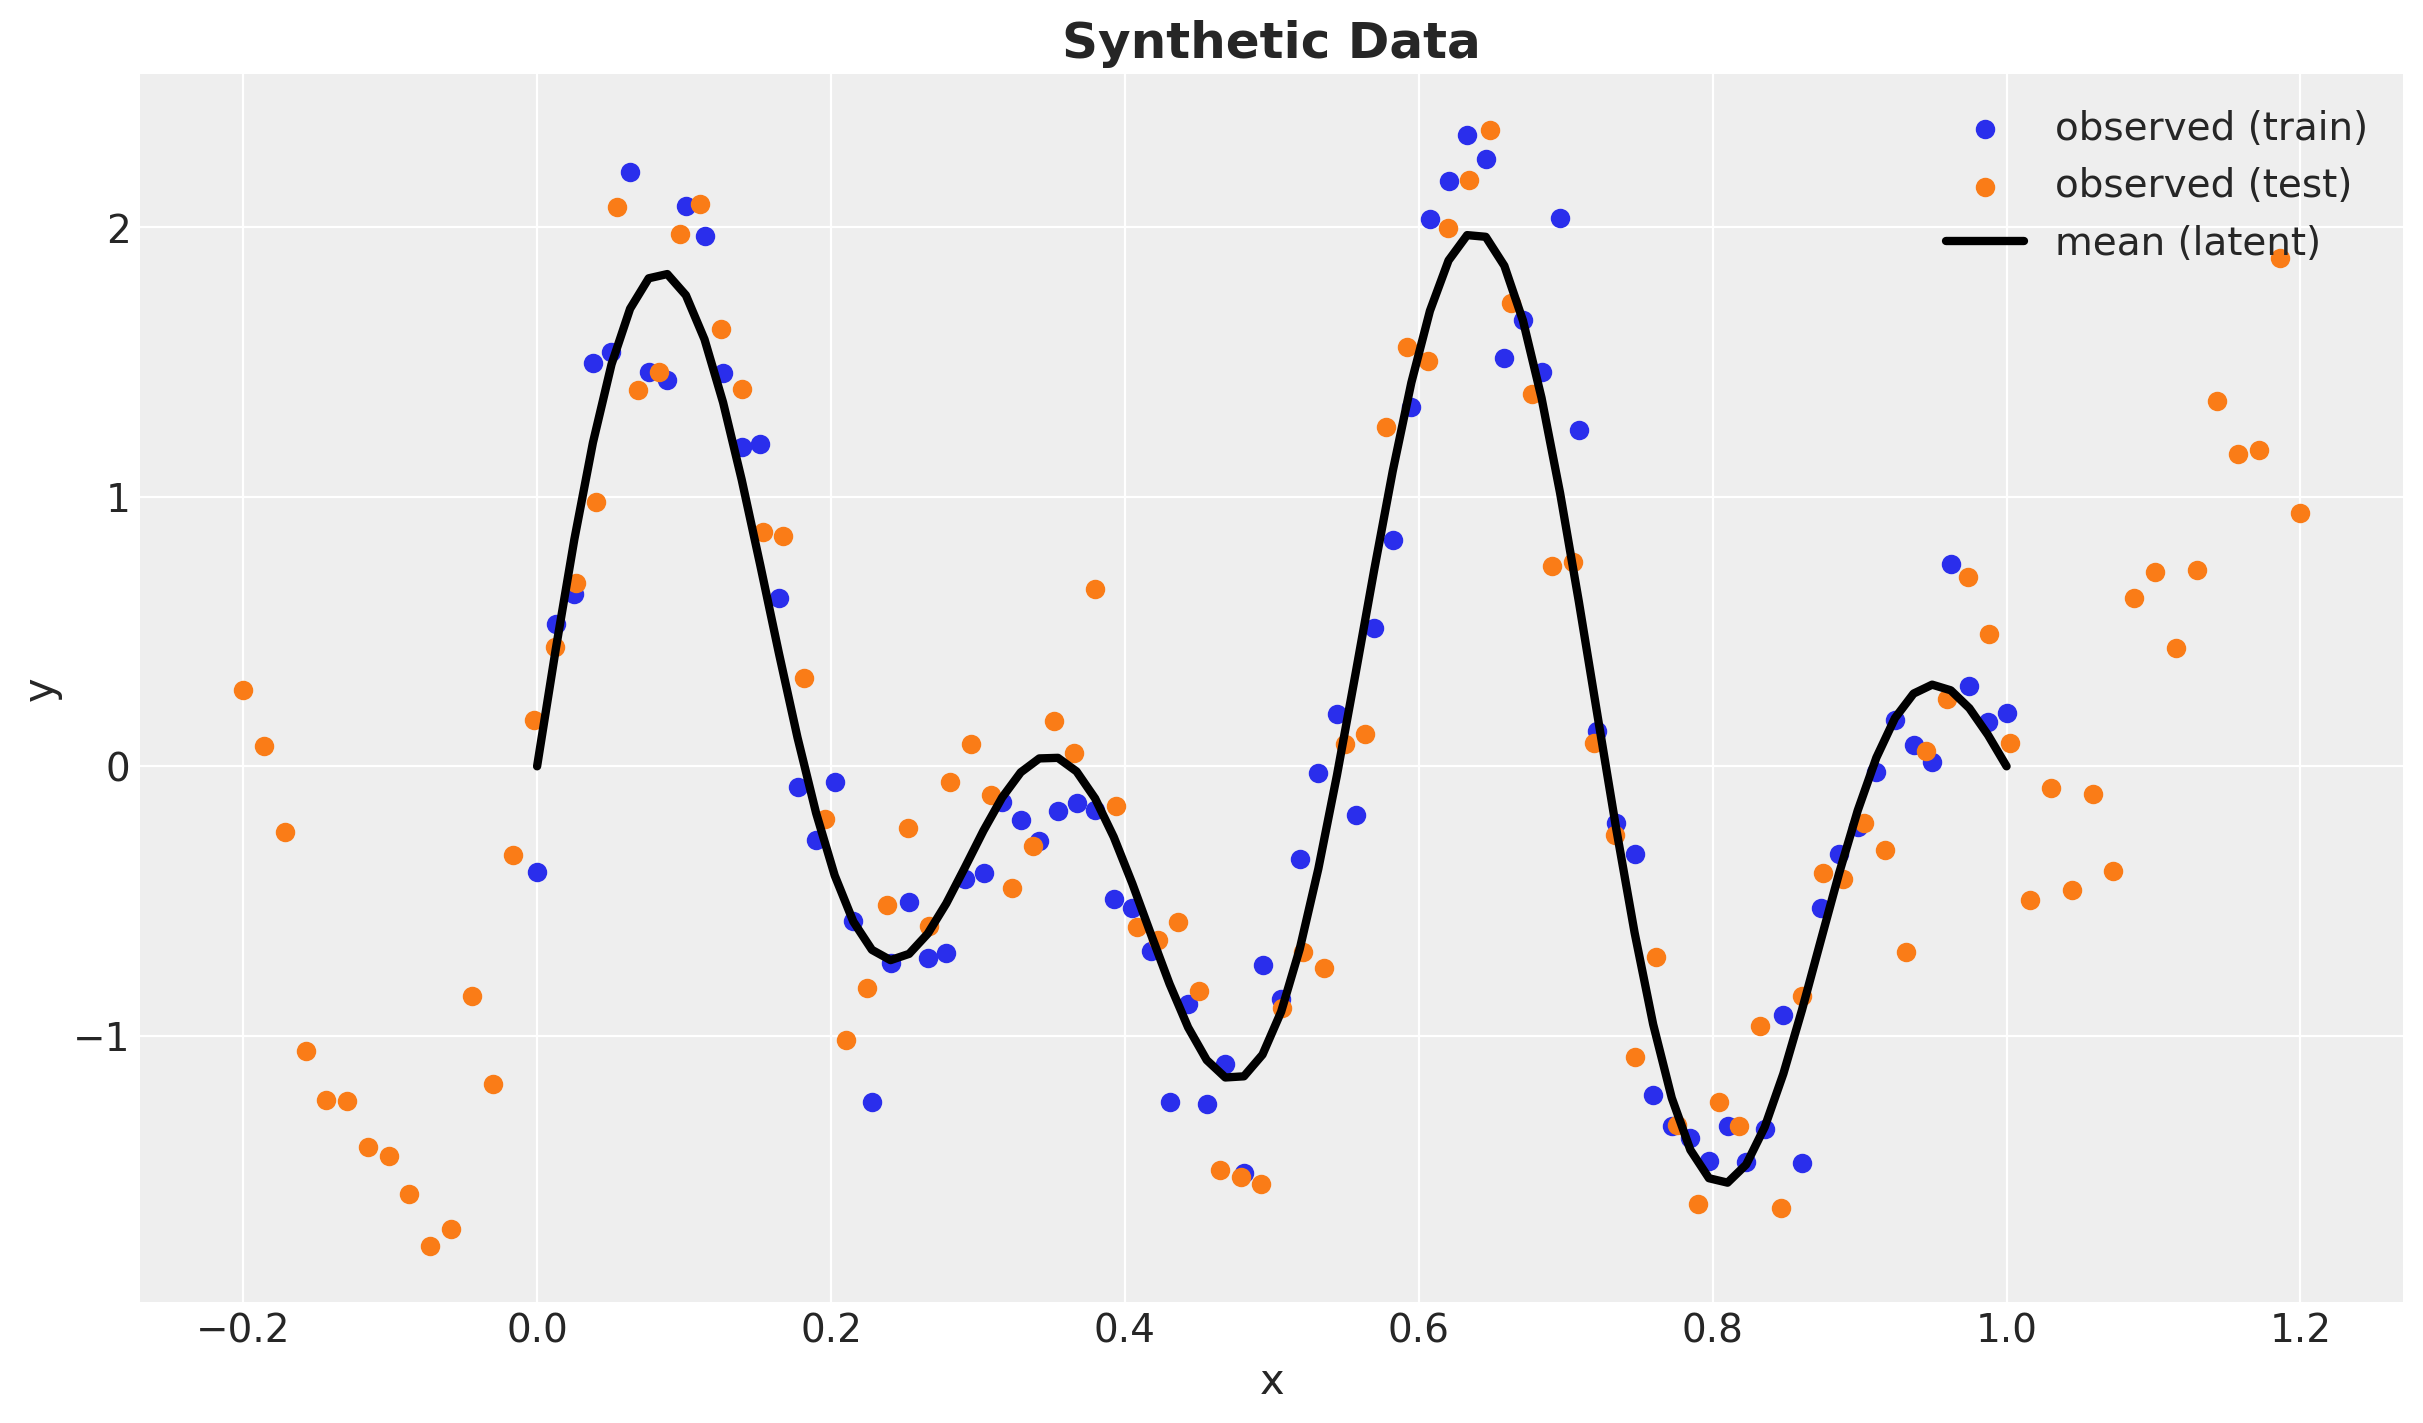

In [3]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.legend(loc="upper right")
ax.set(xlabel="x", ylabel="y")
ax.set_title("Synthetic Data", fontsize=18, fontweight="bold")

$$
\text{cov}(f(x_p), f(x_q)) = k_{\sigma_f, \ell}(x_p, x_q) = \sigma_f \exp\left(-\frac{1}{2\ell^2} ||x_p - x_q||^2\right)
$$

In [4]:
# https://num.pyro.ai/en/stable/examples/gp.html
def squared_exponential_kernel(
    xp: ArrayImpl, xq: ArrayImpl, amplitude: float, length_scale: float
) -> ArrayImpl:
    r = xp[:, None] - xq[None, :]
    delta = (r / length_scale) ** 2
    return amplitude**2 * jnp.exp(-0.5 * delta)

In [5]:
k = squared_exponential_kernel(x_train, x_train, amplitude=1.0, length_scale=0.1)

assert (k == k.T).all().item()
assert (jnp.diag(k) == 1).all().item()
# chol, _ = linalg.cho_factor(k)
# np.linalg.cholesky(k)

Text(0.5, 1.0, 'Squared Exponential Kernel')

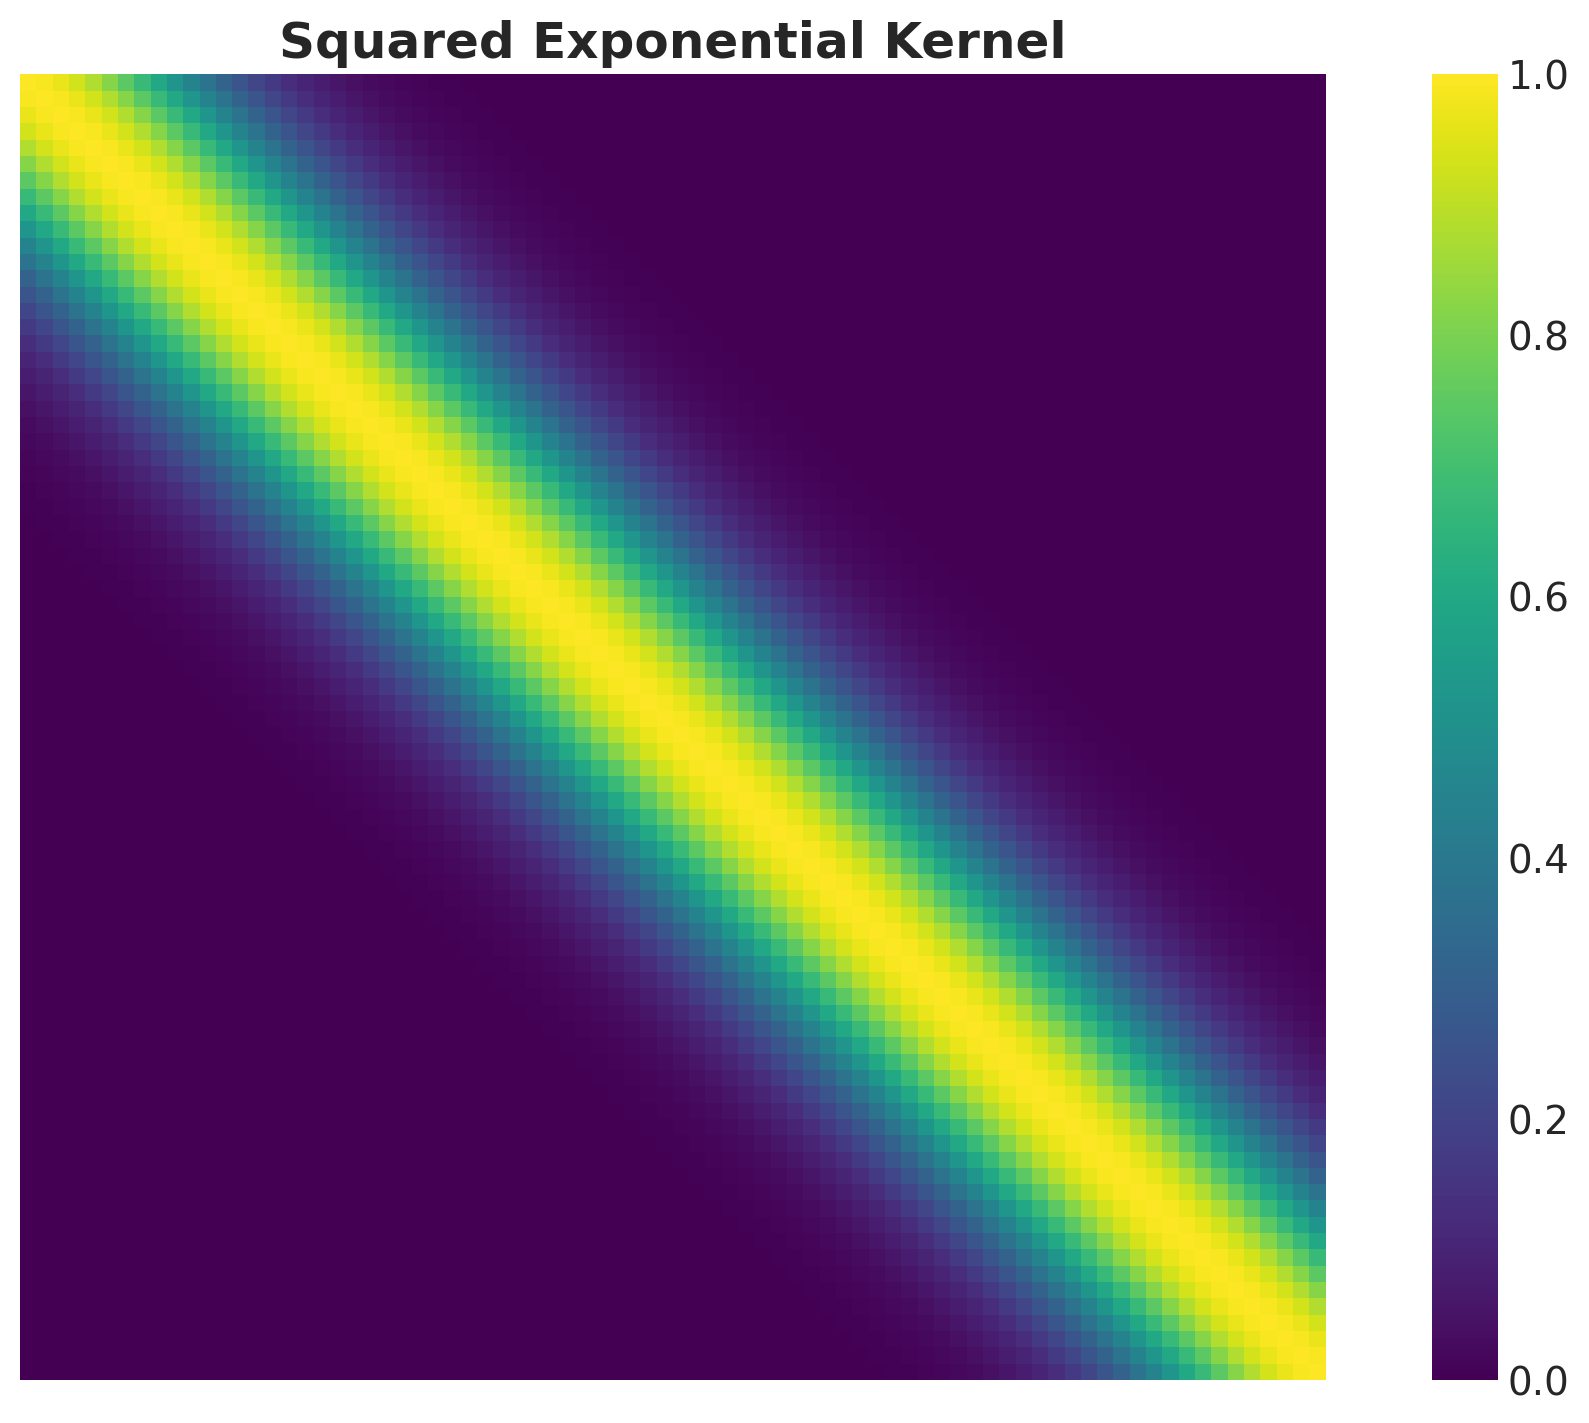

In [6]:
fig, ax = plt.subplots()
sns.heatmap(
    data=k,
    square=True,
    cmap="viridis",
    cbar=True,
    xticklabels=False,
    yticklabels=False,
    ax=ax,
)
ax.set_title("Squared Exponential Kernel", fontsize=18, fontweight="bold")

<Axes: >

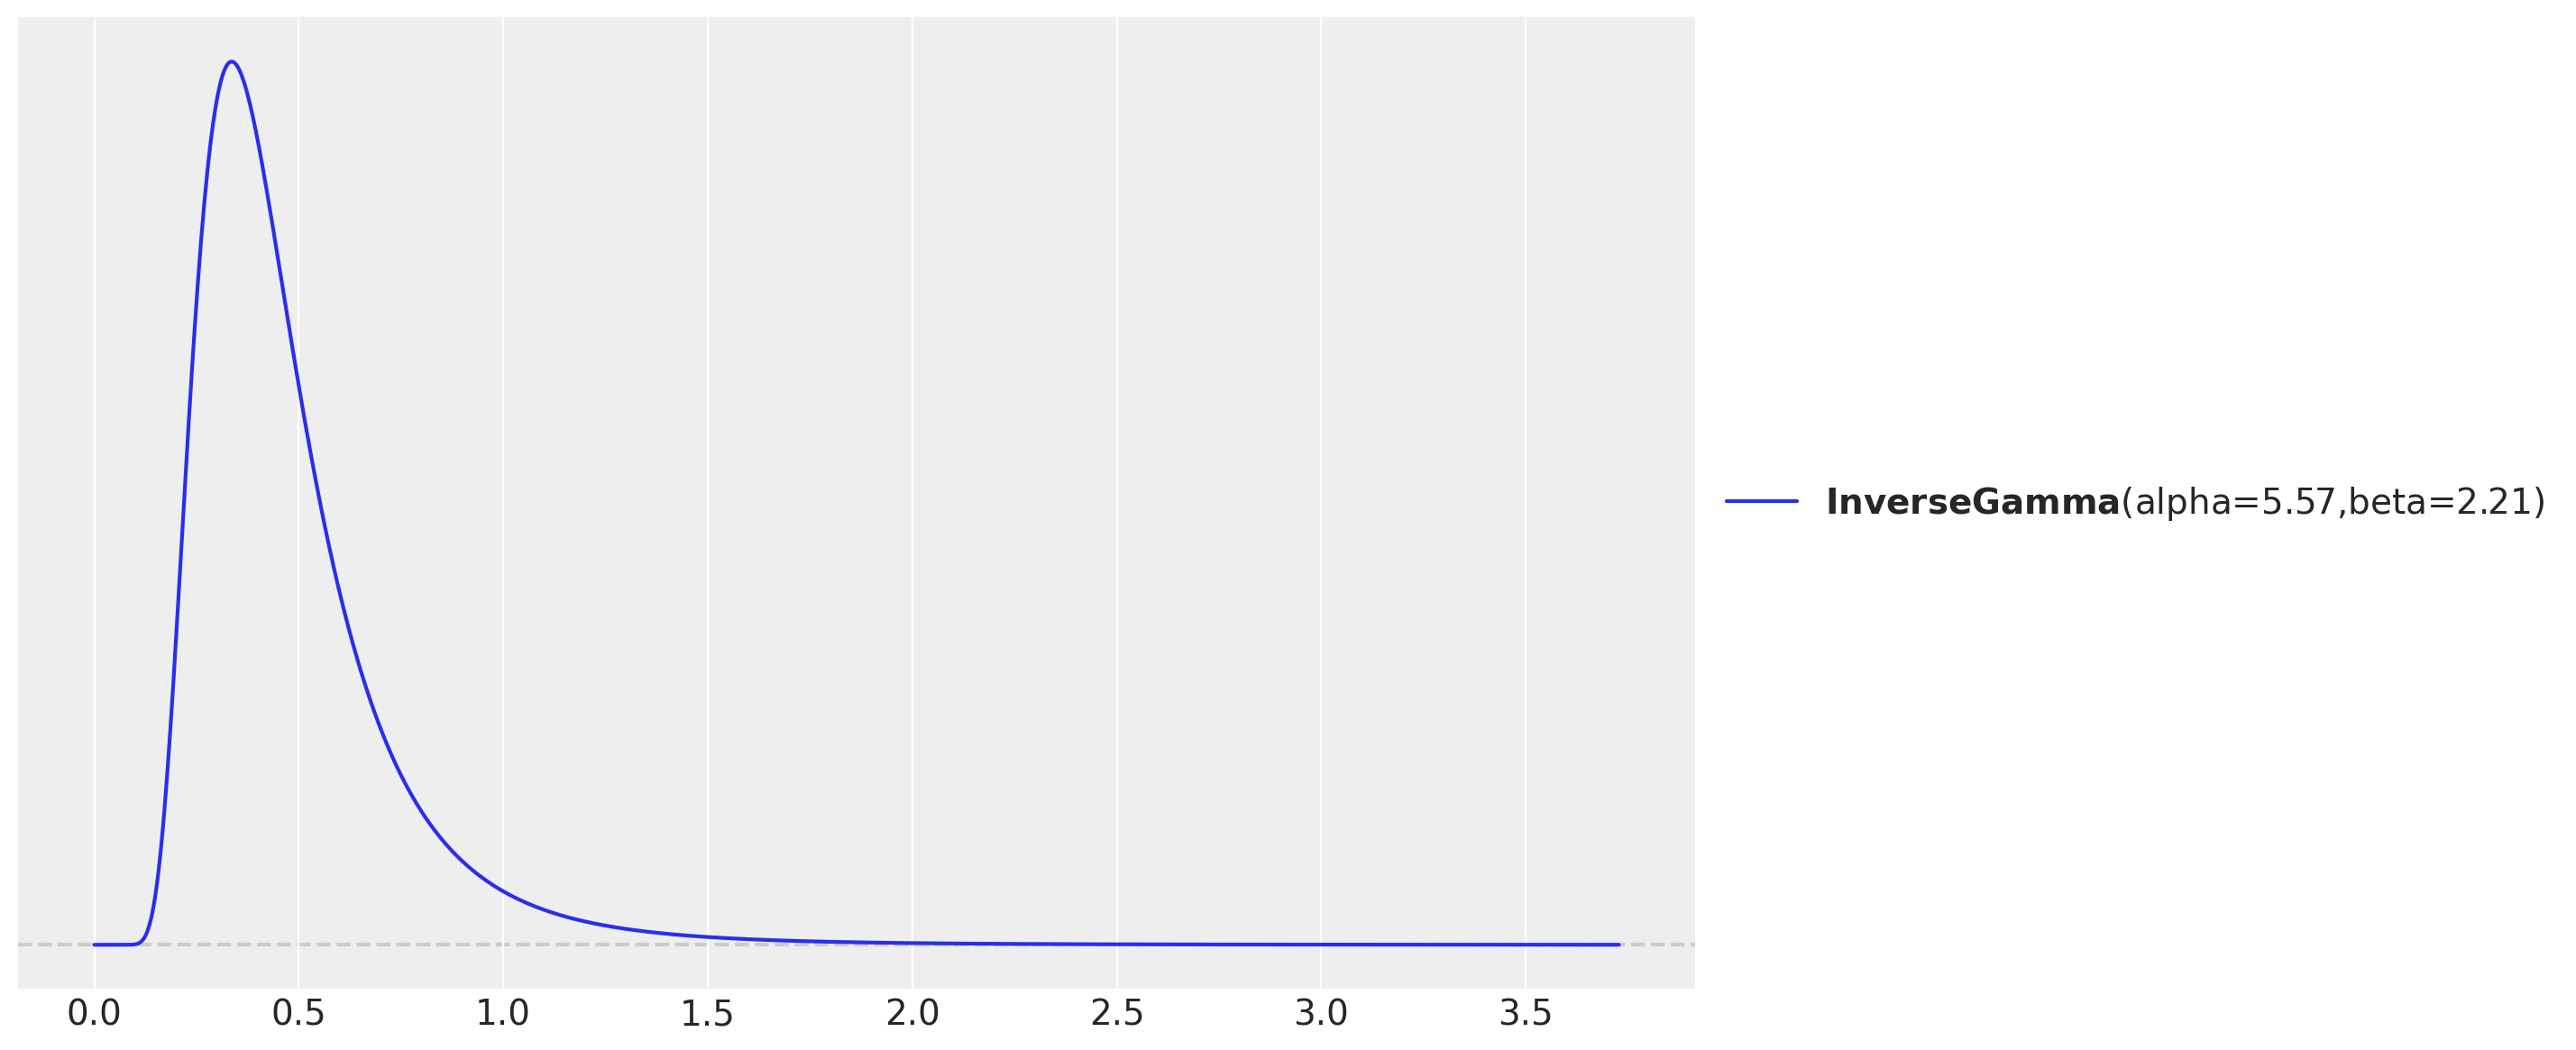

In [7]:
inverse_gamma_params = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=0.01,
    upper=0.9,
    init_guess={"alpha": 5, "beta": 3},
    mass=0.94,
)

fig, ax = plt.subplots()
pz.InverseGamma(**inverse_gamma_params).plot_pdf(ax=ax)

In [8]:
def gp_model(x, y=None, jitter=1.0e-6) -> None:
    kernel_amplitude = numpyro.sample(
        "kernel_amplitude",
        dist.InverseGamma(
            concentration=inverse_gamma_params["alpha"],
            rate=inverse_gamma_params["beta"],
        ),
    )
    noise = numpyro.sample(
        "noise",
        dist.InverseGamma(
            concentration=inverse_gamma_params["alpha"],
            rate=inverse_gamma_params["beta"],
        ),
    )
    kernel_length_scale = numpyro.sample(
        "kernel_length_scale",
        dist.InverseGamma(
            concentration=inverse_gamma_params["alpha"],
            rate=inverse_gamma_params["beta"],
        ),
    )

    mean = jnp.zeros(x.shape[0])
    kernel = squared_exponential_kernel(x, x, kernel_amplitude, kernel_length_scale)
    covariance_matrix = kernel + (noise + jitter) * jnp.eye(x.shape[0])

    numpyro.sample(
        "likelihood",
        dist.MultivariateNormal(loc=mean, covariance_matrix=covariance_matrix),
        obs=y,
    )

In [9]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc


inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
gp_mcmc = run_inference(rng_subkey, gp_model, inference_params, x_train, y_train_obs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [10]:
gp_numpyro_idata = az.from_numpyro(posterior=gp_mcmc)

az.summary(data=gp_numpyro_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel_amplitude,1.685,0.535,0.871,2.629,0.01,0.007,3636.0,3590.0,1.0
kernel_length_scale,0.106,0.011,0.086,0.129,0.00,0.000,3330.0,4072.0,1.0
noise,0.125,0.020,0.089,0.163,0.00,0.000,4837.0,5201.0,1.0


Text(0.5, 0.98, 'GP NumPyro - Trace')

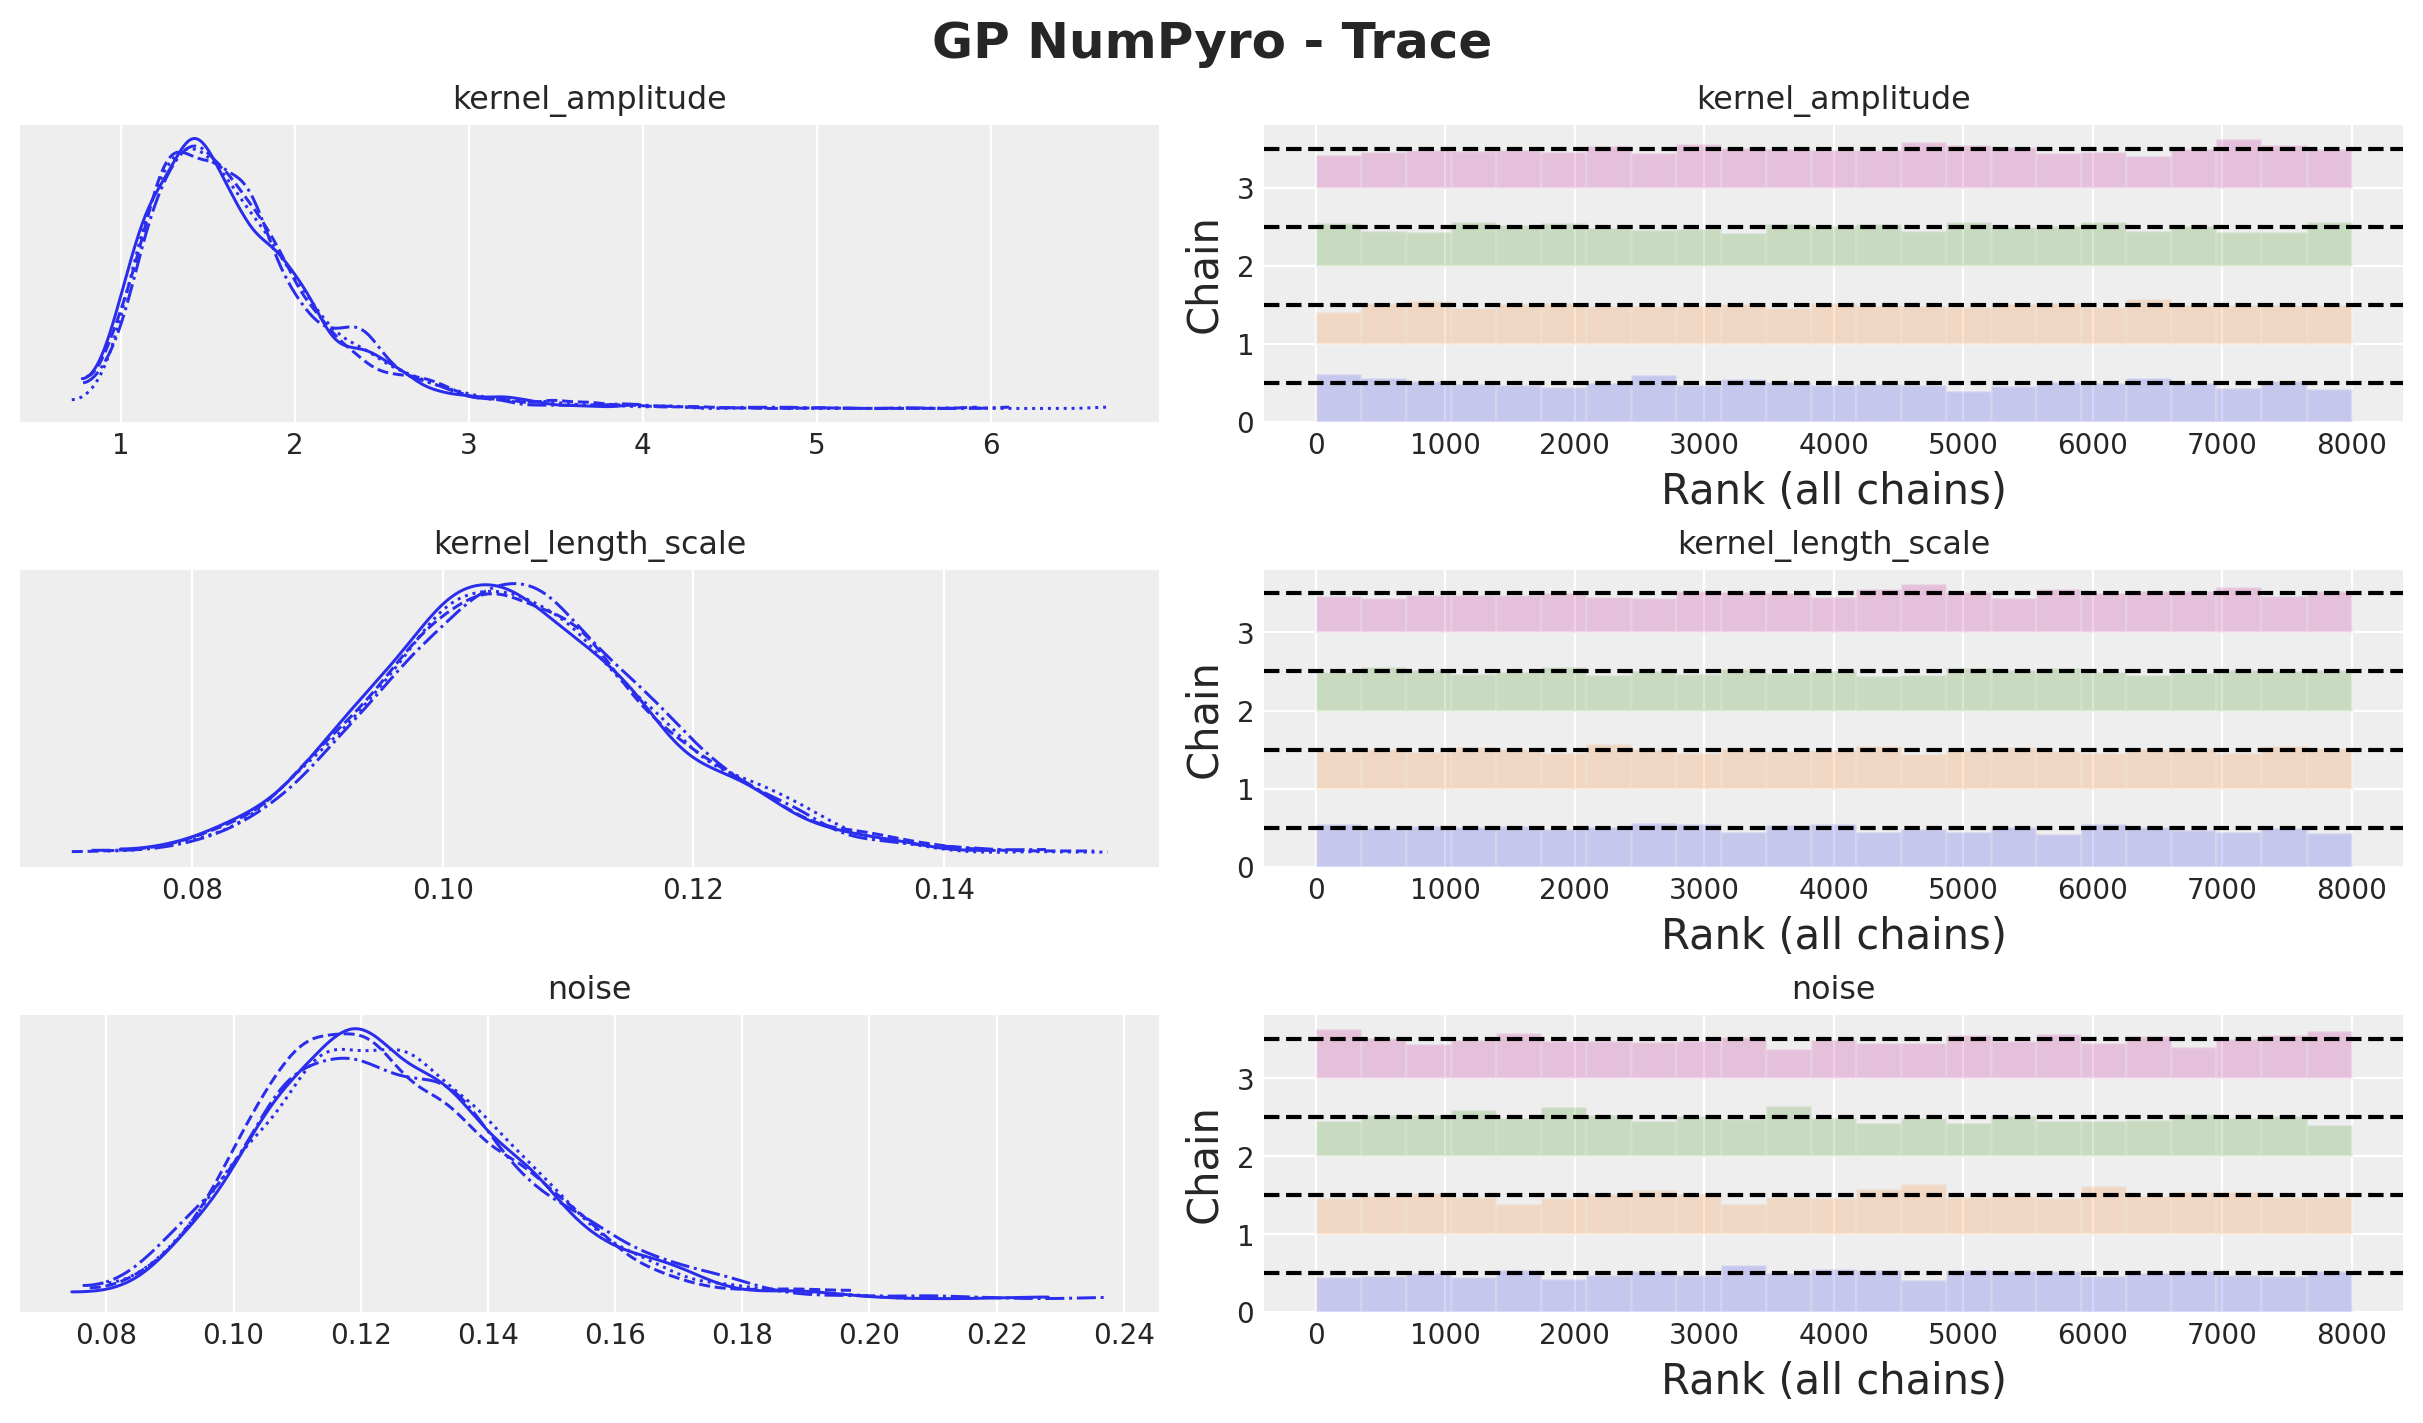

In [11]:
axes = az.plot_trace(
    data=gp_numpyro_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP NumPyro - Trace", fontsize=18, fontweight="bold")

The joint distribution  of \\(y\\) and \\(f_*\\) is given by 

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
\text{MultivariateNormal}(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
$$

Observe that we need to add the term $\sigma^2_n I$ to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise). We now compute the matrix $C$.

As described in our main reference, *to get the posterior distribution over functions we need to restrict this joint
prior distribution to contain only those functions which agree with the observed
data points*, that is, we are interested in computing $f_*|X, y, X_*$. Using the results of [Gaussian Processes for Machine Learning, Appendinx A.2](http://www.gaussianprocess.org/gpml/chapters/RWA.pdf), one can show that 

$$
f_*|X, y, X_* 
\sim
N(\bar{f}_*, \text{cov}(f_*))
$$

where 

$$
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y \in \mathbb{R}^{n_*}
$$

and 

$$
\text{cov}(f_*) = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*) \in M_{n_*}(\mathbb{R})
$$

In [12]:
def get_kernel_matrices_train_test(
    kernel, x, x_test, noise, jitter=1.0e-6, **kernel_kwargs
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    k = kernel(x, x, **kernel_kwargs) + (noise + jitter) * jnp.eye(x.shape[0])
    k_star = kernel(x_test, x, **kernel_kwargs)
    k_star_star = kernel(x_test, x_test, **kernel_kwargs) + (noise + jitter) * jnp.eye(
        x_test.shape[0]
    )
    return k, k_star, k_star_star


def sample_test(rng_key, kernel, x, y, x_test, noise, jitter=1.0e-6, **kernel_kwargs):
    k, k_star, k_star_star = get_kernel_matrices_train_test(
        kernel, x, x_test, noise, jitter, **kernel_kwargs
    )
    k_inv = jnp.linalg.inv(k)
    mean_star = k_star @ (k_inv @ y)
    cov_star = k_star_star - (k_star @ k_inv @ k_star.T)
    return random.multivariate_normal(rng_key, mean=mean_star, cov=cov_star)

In [13]:
rng_key, rng_subkey = random.split(rng_key)

vmap_args = (
    random.split(
        rng_subkey, inference_params.num_samples * inference_params.num_chains
    ),
    gp_mcmc.get_samples()["noise"],
    gp_mcmc.get_samples()["kernel_amplitude"],
    gp_mcmc.get_samples()["kernel_length_scale"],
)

posterior_predictive_test = vmap(
    lambda rng_key, noise, amplitude, length_scale: sample_test(
        rng_key,
        squared_exponential_kernel,
        x_train,
        y_train_obs,
        x_test,
        noise,
        amplitude=amplitude,
        length_scale=length_scale,
    ),
)(*vmap_args)

gp_numpyro_idata.extend(
    az.from_dict(
        posterior_predictive={
            "y_pred_test": posterior_predictive_test[None, ...],
        },
        coords={"x": x_test},
        dims={"y_pred_test": ["x"]},
    )
)

Text(0.5, 1.0, 'GP NumPyro Model - Posterior Predictive')

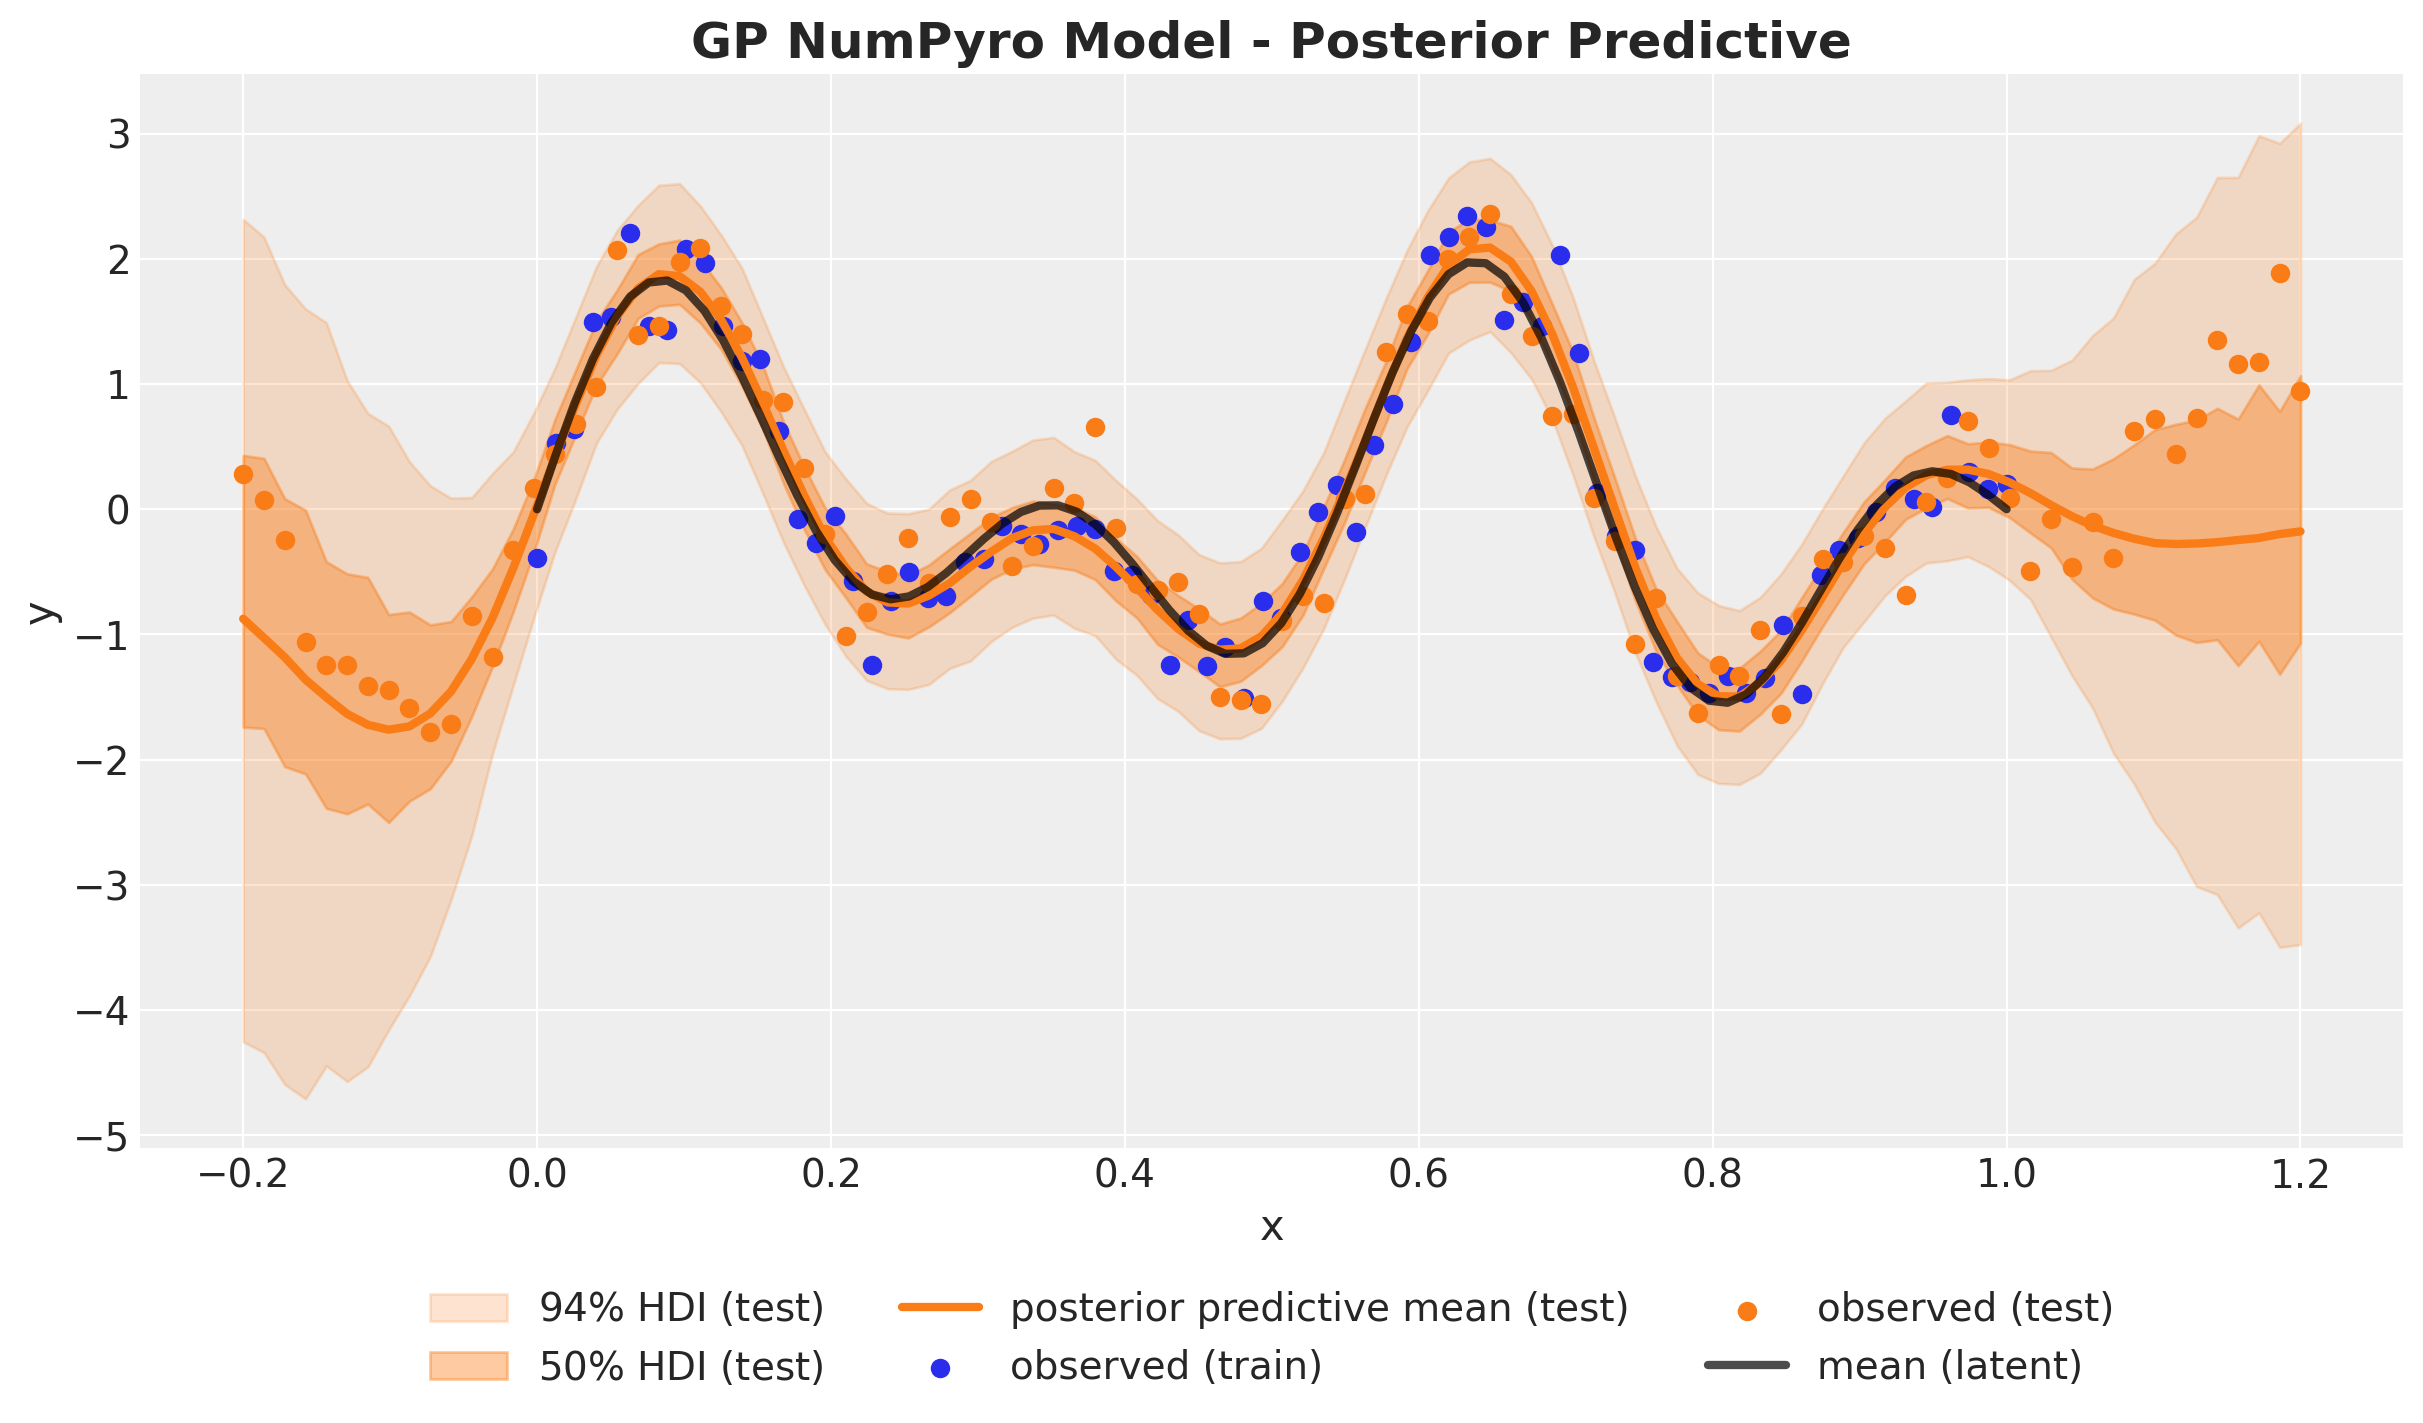

In [14]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Posterior Predictive", fontsize=18, fontweight="bold")

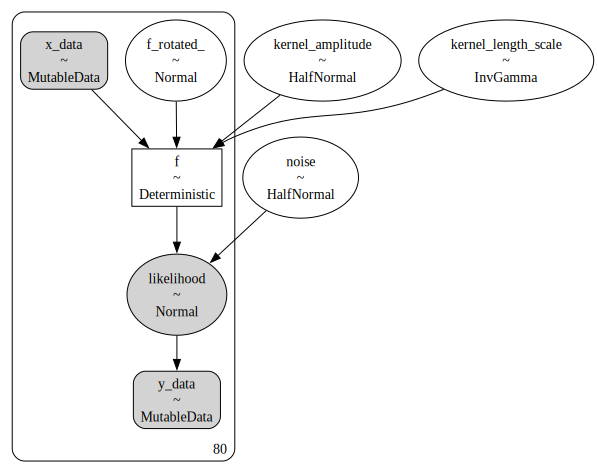

In [16]:
with pm.Model() as gp_pymc_model:
    x_data = pm.MutableData("x_data", value=x_train)
    y_data = pm.MutableData("y_data", value=y_train_obs)

    kernel_amplitude = pm.HalfNormal("kernel_amplitude", sigma=1.0)
    kernel_length_scale = pm.InverseGamma(
        "kernel_length_scale",
        alpha=inverse_gamma_params["alpha"],
        beta=inverse_gamma_params["beta"],
    )
    noise = pm.HalfNormal("noise", sigma=1.0)

    mean = pm.gp.mean.Zero()
    cov = kernel_amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=kernel_length_scale)
    gp = pm.gp.Latent(mean_func=mean, cov_func=cov)
    f = gp.prior("f", X=x_data[:, None])

    pm.Normal("likelihood", mu=f, sigma=noise, observed=y_data)


pm.model_to_graphviz(model=gp_pymc_model)

In [17]:
rng_key, rng_subkey = random.split(rng_key)

with gp_pymc_model:
    gp_pymc_idata = pm.sample(
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

Compiling...
Compilation time = 0:00:02.541673
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:05:05.038222
Transforming variables...
Transformation time = 0:00:01.517430


Text(0.5, 0.98, 'GP PyMC - Trace')

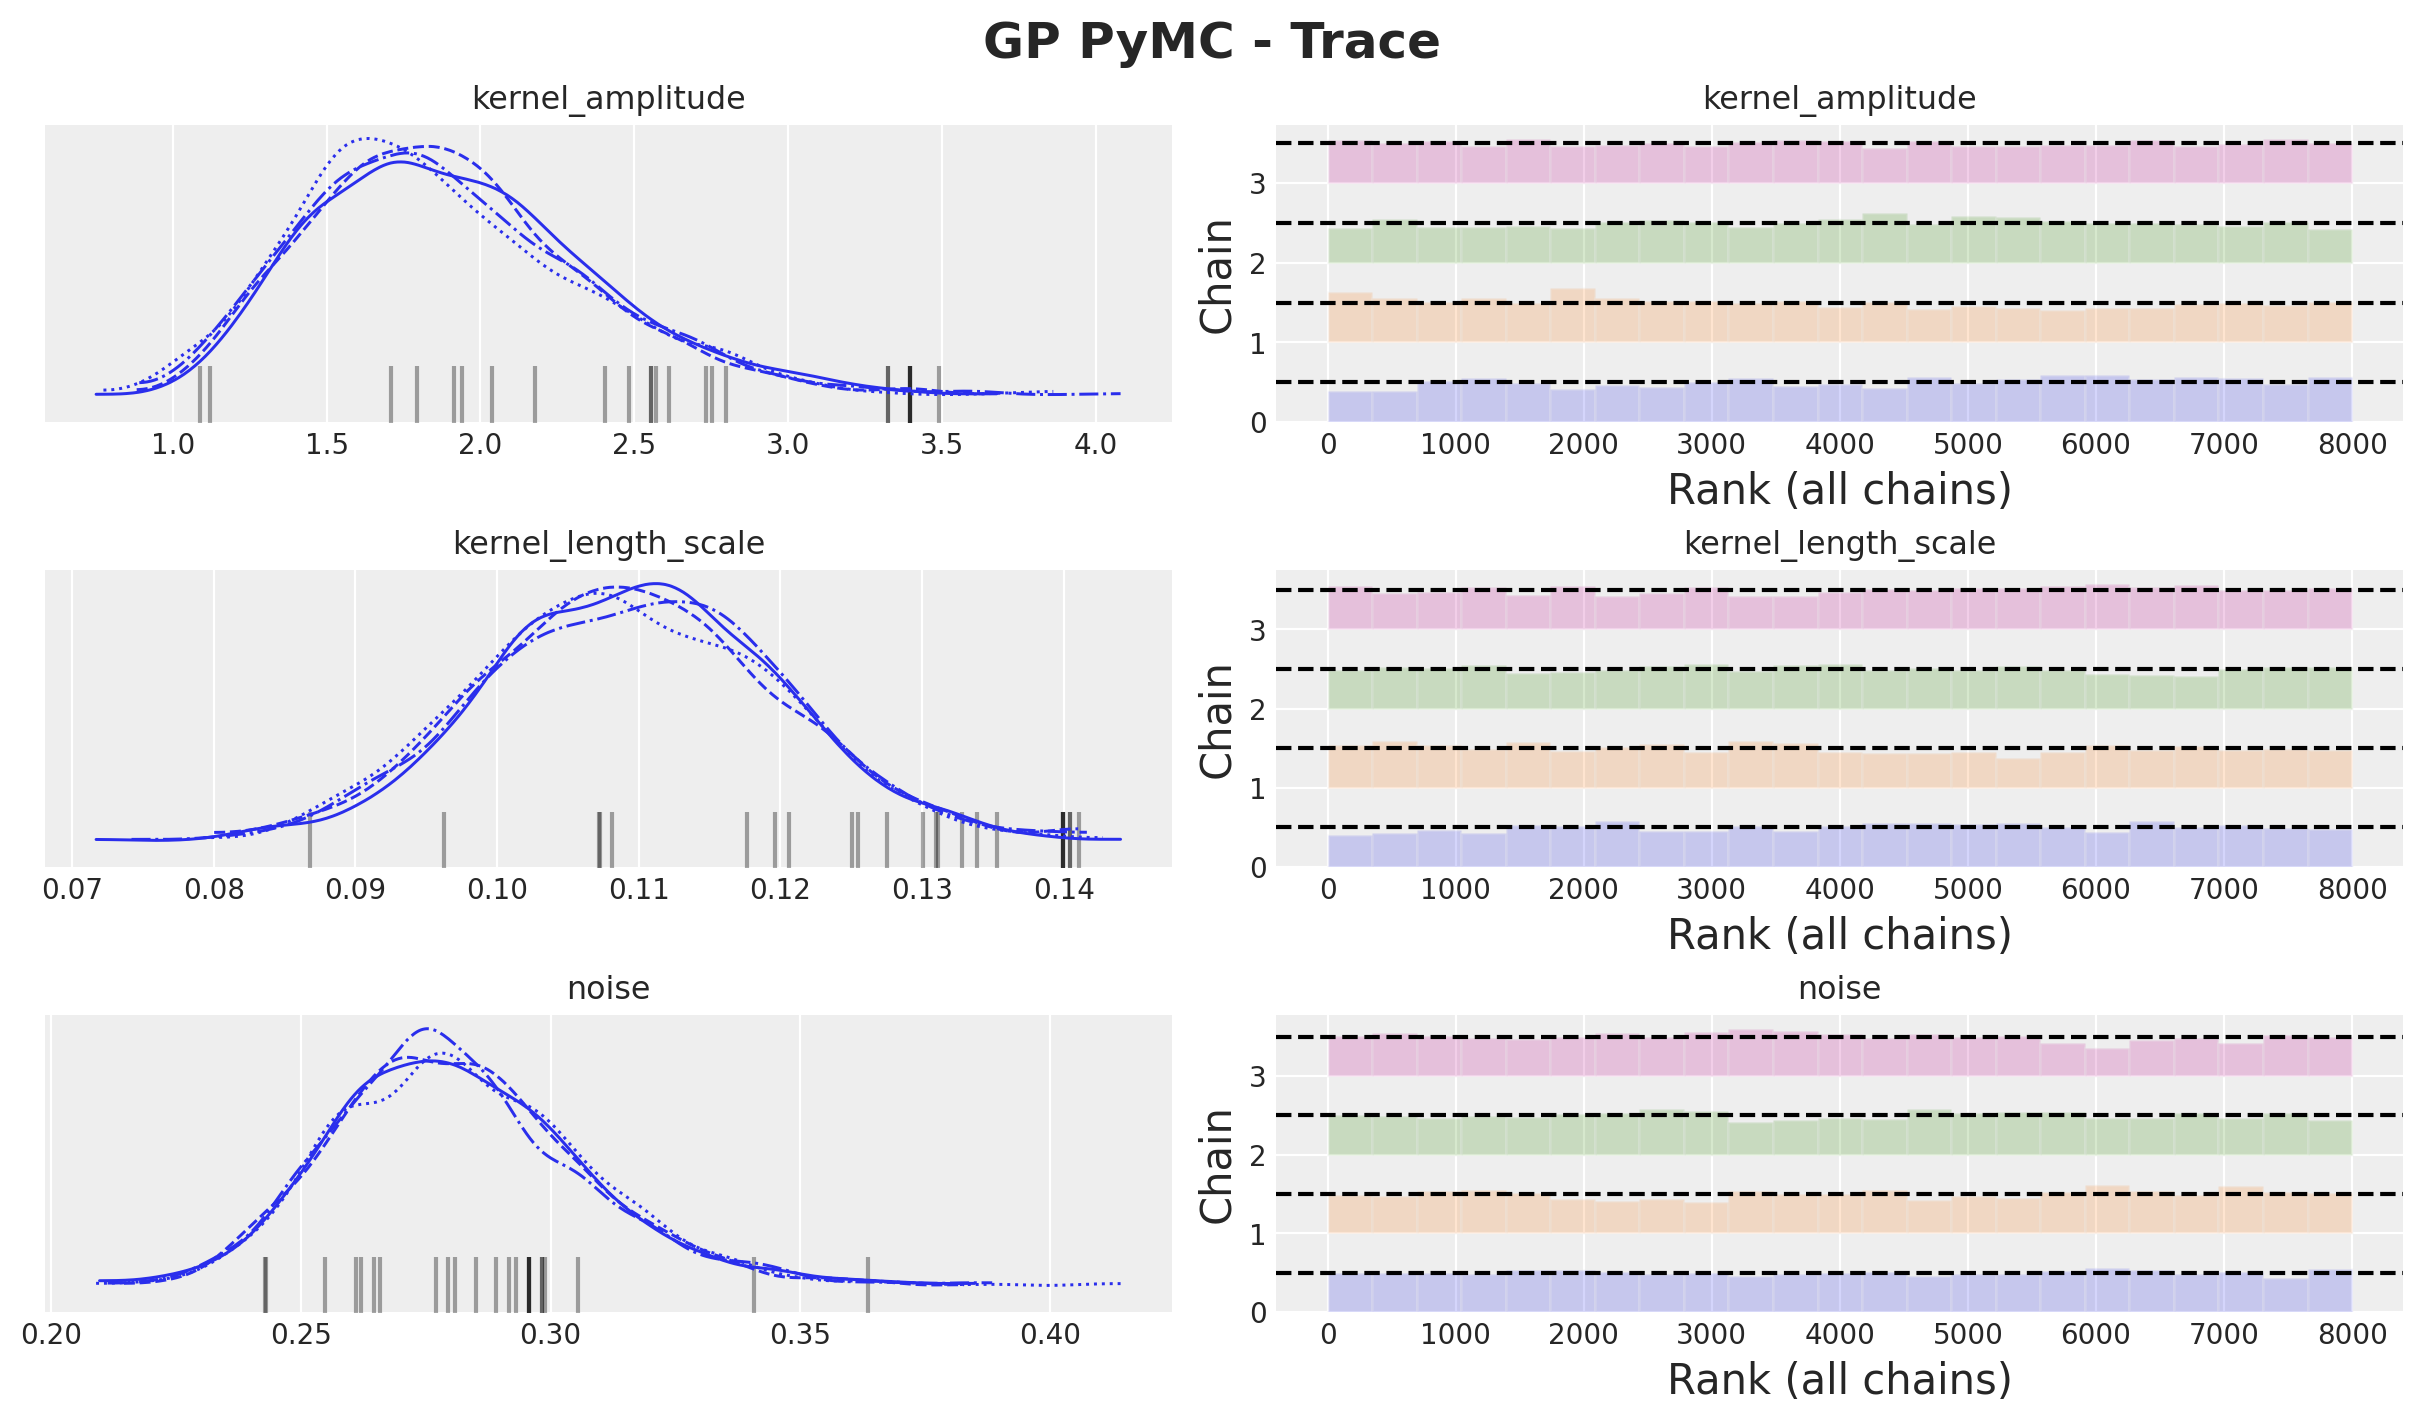

In [18]:
axes = az.plot_trace(
    data=gp_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP PyMC - Trace", fontsize=18, fontweight="bold")

In [21]:
with gp_pymc_model:
    x_star_data = pm.MutableData("x_star_data", x_test)
    y_pred_test = gp.conditional("y_pred_test", x_star_data[:, None])
    gp_pymc_idata.extend(
        pm.sample_posterior_predictive(
            trace=gp_pymc_idata,
            var_names=["y_pred_test", "likelihood"],
            random_seed=rng_subkey[1].item(),
        )
    )

Sampling: [likelihood, y_pred_test]


In [23]:
gp_pymc_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0.5, 1.0, 'GP NumPyro Model - Posterior Predictive')

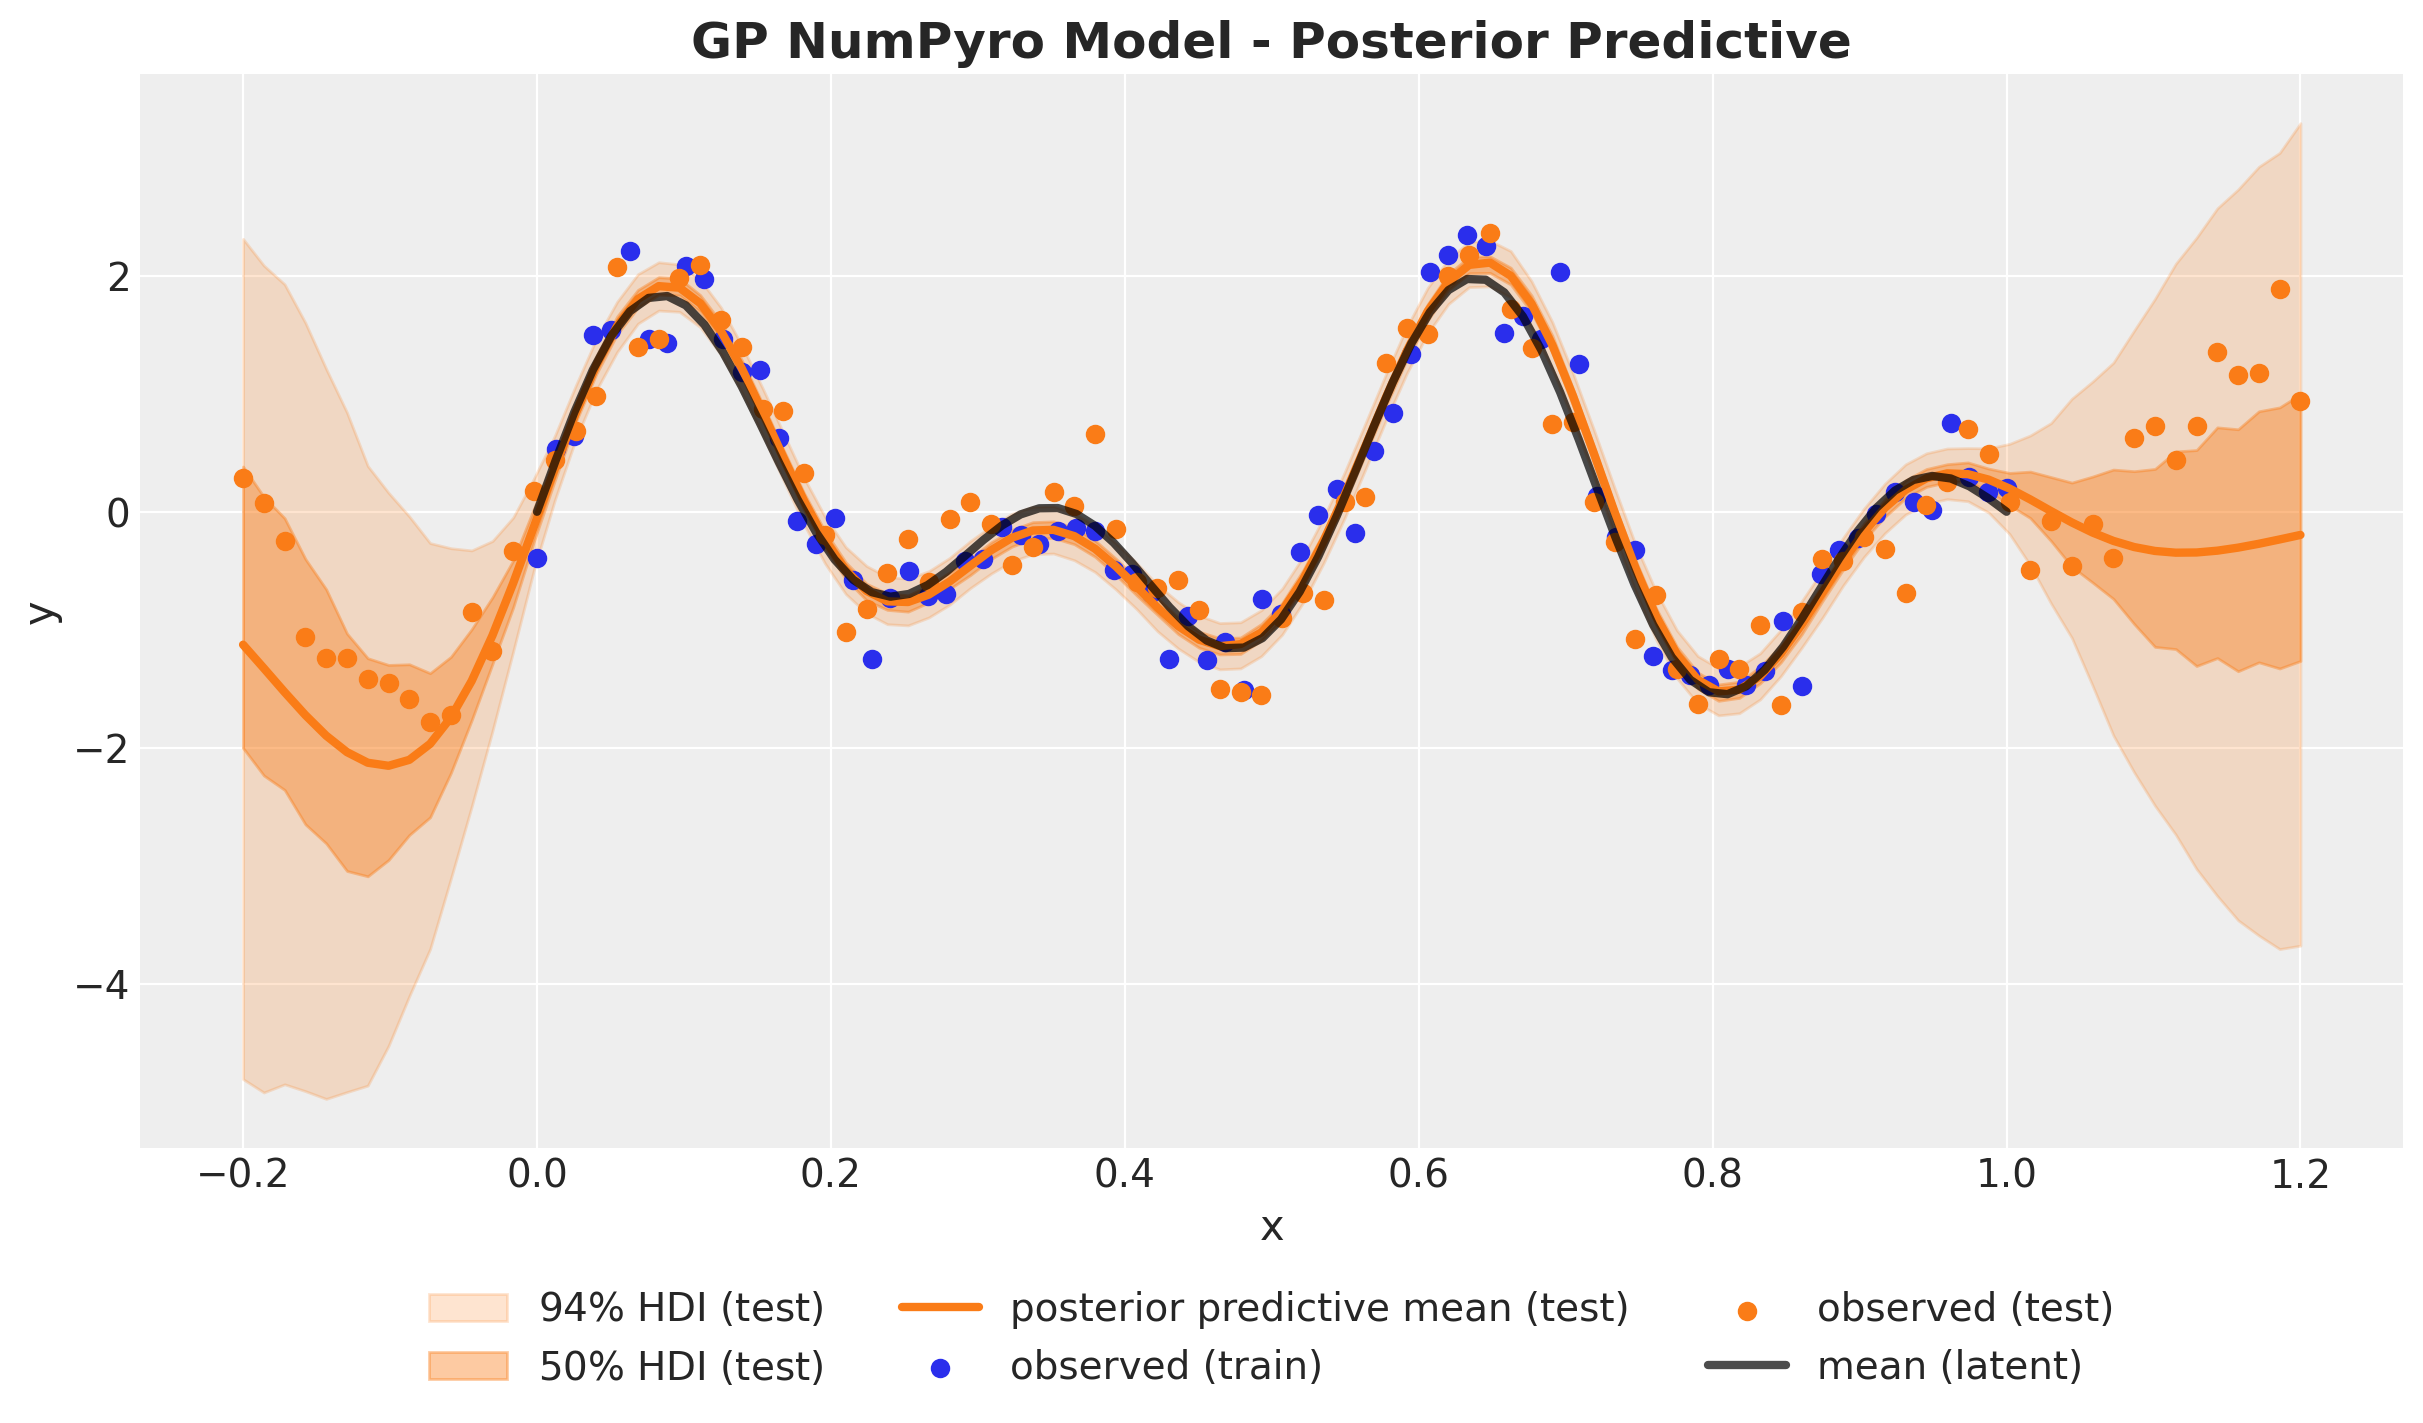

In [24]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_pymc_idata.posterior_predictive["y_pred_test"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Posterior Predictive", fontsize=18, fontweight="bold")